In [1]:
import os
import pickle
import keras
import time

import numpy as np
import pandas as pd
import seaborn as sn
import random as rn
import tensorflow as tf
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Activation
from sklearn.model_selection import GridSearchCV

from keras.models import load_model

Using TensorFlow backend.


In [2]:
def MLP_print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
#     df_cmx.to_excel('Excel/doc2vec_headline_MLP.xlsx', encoding='UTF-16')
    plt.figure(figsize = (12,8))
    sn.heatmap(df_cmx, annot=True, fmt="d") ### ヒートマップの表示仕様
    plt.title("Confusion Matrix")
    plt.xlabel("predict_classes")
    plt.ylabel("true_classes")
    print('スポーツ : 0 / IT : 1 / 映画 : 2 / ライフ : 3')
    plt.show()

# dmpv

In [3]:
# データのロード
data_c=pickle.load(open('/Users/Baron/Document/text_mining/Data/pickle/Doc2Vec/Headline/d2v_headline_dmpv.pickle', "rb"))

z_c = data_c[0]   # 内容
y_c = data_c[1]   # ラベル
x_c = data_c[2]   # 特徴量

kf = KFold(n_splits=5, shuffle=True, random_state=0)
nb_classes = 4
# ラベルデータをone-hotベクトルに直す --- (*3)
y_c = keras.utils.np_utils.to_categorical(y_c, nb_classes)

# データの次元数
x_size = x_c[0].shape[0]
y_size = y_c[0].shape[0]

A_index_c=[]
B_index_c=[]
C_index_c=[]
D_index_c=[]
E_index_c=[]
F_index_c=[]

# 交差検証
for train, test in kf.split(x_c):
    A_c=np.empty((0,x_size), int)
    B_c=np.empty((0,x_size), int)
    C_c=np.empty((0,y_size), int)
    D_c=np.empty((0,y_size), int)
    E_c = []
    F_c = []
    for i in test:
        A_c = np.append(A_c, [x_c[i]], axis=0)           # x_test
        C_c = np.append(C_c, [y_c[i]], axis=0)           # y_test
        E_c.append(z_c[i])                                     # z_test
    A_index_c.append(A_c)
    C_index_c.append(C_c)
    E_index_c.append(E_c)
    for j in train:
        B_c = np.append(B_c, [x_c[j]], axis=0)            # x_train
        D_c = np.append(D_c, [y_c[j]], axis=0)           # y_train
        F_c.append(z_c[j])                                      # z_train
    B_index_c.append(B_c)
    D_index_c.append(D_c)
    F_index_c.append(F_c)

In [4]:
def MLP_dmpv(x_test, x_train, y_test, y_train, z_test, z_train, x_size, p):
    # MLPモデル構造を定義 --- (*5)
    MLP_model = Sequential()

    MLP_model.add(Dense(128, activation='relu', input_shape=(x_size,)))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(nb_classes, activation='softmax'))

    # モデルをコンパイル --- (*6)
    MLP_model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    t1 = time.time()                 #　開始
    # 学習を実行 --- (*7)
    hist = MLP_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time.time()                #　終了
    
   # モデルの保存
    MLP_model.save('./model/dmpv_model_'+str(p)+'.hdf5')
    
    # モデルのロード
    model = load_model('./model/dmpv_model_'+str(p)+'.hdf5')
    #  混同行列
    predict_classes = model.predict_classes(x_test[1:10000]) ### 予測したラベルを取得
    true_classes = np.argmax(y_test[1:10000], 1) ### 実際のラベルを取得

    # 評価する ---(*8)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('\n')
    print("正解率=", score[1], 'loss=', score[0])

    #  適応率, 再現率, F値
    rep = metrics.classification_report(true_classes, predict_classes)
    print(rep)

    # 学習の様子をグラフへ描画 --- (*10)
    # Accuracy
    plt.figure(figsize=(20, 5)) # figureの縦横の大きさ
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    MLP_print_cmx(true_classes, predict_classes)

    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"処理時間：{elapsed_time}"+"[s]")

    LABELS = ["スポーツ", "IT", "映画", "ライフ"]
    A=[]
    B=[]
    C=[]
    D=[]
    for i, j, k in zip(x_test, y_test, z_test):
        pre = model.predict(np.array([i]))[0]
        n = pre.argmax()
        l=np.where(j==1.0)
        if LABELS[n]!=LABELS[l[0][0]]:
            A.append(LABELS[n])
            B.append(pre[n])
            C.append(LABELS[l[0][0]])
            D.append(k)

    df=pd.DataFrame({'text':D,
                                     'true_label':C, 
                                    'pre_label':A,
                                    'prediction':B}
                                   )

    #     df.to_excel('Excel/TF-IDF_MLP_'+str(p)+'.xlsx', encoding='UTF-16')
    display(df)

W0320 21:45:33.518757 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0320 21:45:33.603219 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0320 21:45:33.639151 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0320 21:45:33.728526 140735485961088 deprecation_wrapper.py:119] From /Users/Baron/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 1s 264us/step - loss: 1.1512 - acc: 0.5078 - val_loss: 0.8413 - val_acc: 0.6766
Epoch 2/50
2806/2806 [==============================] - 0s 39us/step - loss: 0.8104 - acc: 0.6989 - val_loss: 0.6532 - val_acc: 0.7906
Epoch 3/50
2806/2806 [==============================] - 0s 41us/step - loss: 0.6654 - acc: 0.7594 - val_loss: 0.5562 - val_acc: 0.8148
Epoch 4/50
2806/2806 [==============================] - 0s 36us/step - loss: 0.5822 - acc: 0.7894 - val_loss: 0.5387 - val_acc: 0.8077
Epoch 5/50
2806/2806 [==============================] - 0s 40us/step - loss: 0.5313 - acc: 0.8097 - val_loss: 0.5038 - val_acc: 0.8177
Epoch 6/50
2806/2806 [==============================] - 0s 34us/step - loss: 0.4714 - acc: 0.8354 - val_loss: 0.4959 - val_acc: 0.8262
Epoch 7/50
2806/2806 [==============================] - 0s 34us/step - loss: 0.4275 - acc: 0.8532 - val_loss: 0.4738 - val_acc: 0.8333
Epoch 8

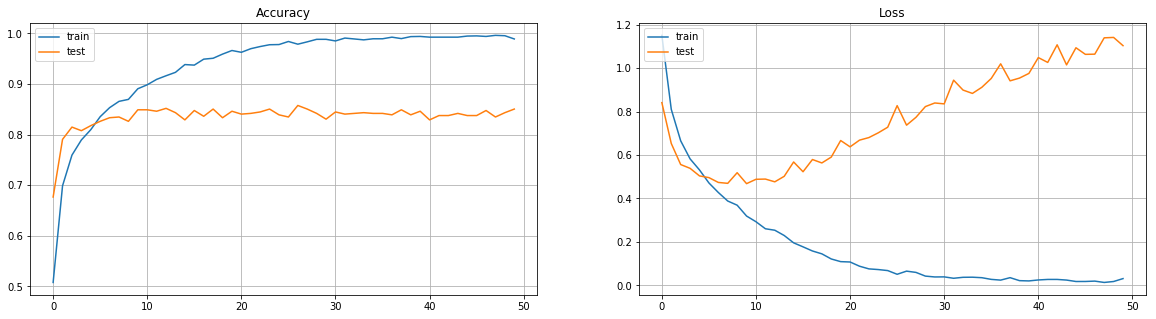

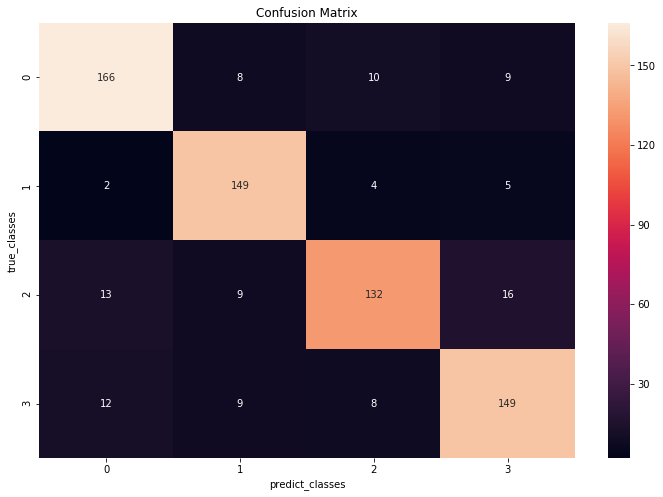

処理時間：8.223823070526123[s]


,text,true_label,pre_label,prediction
0,DeNA春田真会長、プロ野球参入の理由は「12個しかないアセットを会社で持つ重みがある」,スポーツ,IT,0.999537
1,“史上最低の外国人選手”が母国でツイッター更新、ファンの怒りは増幅,スポーツ,映画,0.605113
2,「ちょっと意外」?? 香川真司の運動量がドイツ１に,スポーツ,映画,0.693365
3,「直訳かよ」MLB日本開幕戦の動画が話題に,スポーツ,映画,0.901334
4,【Sports Watch】内田篤人、好きな女性芸能人を前に「真っ白なんですけど」,スポーツ,ライフ,0.983156
5,【Sports Watch】国母の服装問題に、山本KID「くだらん」,スポーツ,映画,0.977595
6,【Sports Watch】大沢親分死去、星野氏「win-winの関係のトレードをして貰った」,スポーツ,IT,0.789478
7,【Sports Watch】宮崎大輔に、妻は“朝まで遊んで。スポーツ選手ですよ”,スポーツ,ライフ,0.999999
8,【Sports Watch】松坂大輔「もう勝ったと思って寝るわ」→大逆転負け,スポーツ,映画,0.946612
9,【Sports Watch】浅尾美和、新パートナーとはやくもちぐはぐ!?,スポーツ,ライフ,0.570840


In [5]:
MLP_dmpv(A_index_c[0], B_index_c[0], C_index_c[0], D_index_c[0], E_index_c[0], F_index_c[0], x_size, p=0)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 1s 237us/step - loss: 1.1341 - acc: 0.5510 - val_loss: 0.8338 - val_acc: 0.6966
Epoch 2/50
2806/2806 [==============================] - 0s 39us/step - loss: 0.7877 - acc: 0.7227 - val_loss: 0.6896 - val_acc: 0.7707
Epoch 3/50
2806/2806 [==============================] - 0s 50us/step - loss: 0.6743 - acc: 0.7616 - val_loss: 0.6111 - val_acc: 0.7849
Epoch 4/50
2806/2806 [==============================] - 0s 35us/step - loss: 0.5858 - acc: 0.7926 - val_loss: 0.5784 - val_acc: 0.8020
Epoch 5/50
2806/2806 [==============================] - 0s 37us/step - loss: 0.5085 - acc: 0.8182 - val_loss: 0.5731 - val_acc: 0.7949
Epoch 6/50
2806/2806 [==============================] - 0s 46us/step - loss: 0.4617 - acc: 0.8411 - val_loss: 0.5792 - val_acc: 0.7977
Epoch 7/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.4072 - acc: 0.8514 - val_loss: 0.5670 - val_acc: 0.7977
Epoch 8

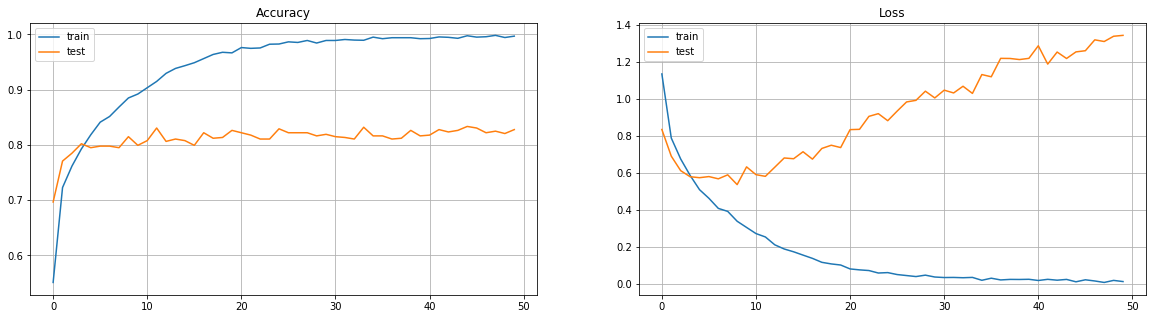

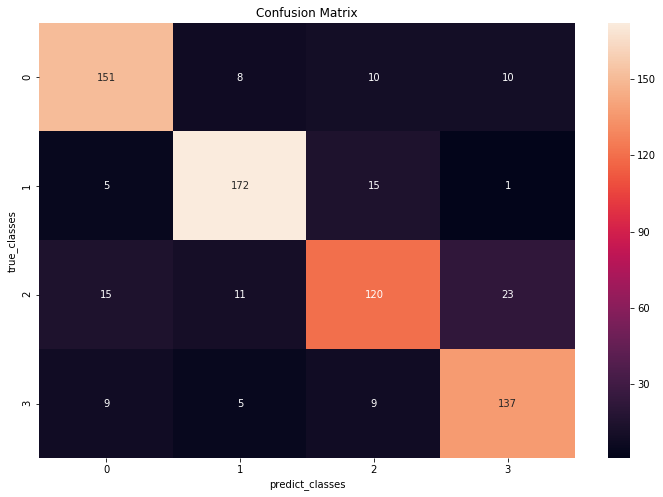

処理時間：7.458504915237427[s]


,text,true_label,pre_label,prediction
0,“日本の心臓”遠藤保仁の凄すぎるプレー、日本を救った1本のパスとは？,スポーツ,IT,0.999172
1,“異常な時代”の終焉、レーザーレーサーの今とは,スポーツ,IT,0.999856
2,「なぜ足で止めようと」自分の車に轢かれ今季絶望の選手,スポーツ,映画,0.924922
3,「僕らの年代では一番うまい」 中田英が絶賛する日本人選手の現在とは・・・,スポーツ,IT,0.575307
4,「泣いてんのかこれ」、“熱すぎる”アナウンサーが劇的結末に大興奮,スポーツ,映画,0.996317
5,【Sports Watch】イチローの米球宴落選に、“過去の活躍とか関係ない”,スポーツ,映画,0.999791
6,【Sports Watch】ヨナのミスジャンプに加点、集まる疑問視する声,スポーツ,映画,1.000000
7,【Sports Watch】上田桃子「この度、結婚致します」,スポーツ,ライフ,0.999984
8,【Sports Watch】仕事中、サッチーから“もうやめて帰ってこい”と言われるノムさん,スポーツ,ライフ,0.824863
9,【Sports Watch】全治6カ月、代表入りが危ぶまれる丸山にかけた澤の言葉とは？,スポーツ,IT,0.967671


In [6]:
MLP_dmpv(A_index_c[1], B_index_c[1], C_index_c[1], D_index_c[1], E_index_c[1], F_index_c[1], x_size, p=1)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 1s 305us/step - loss: 1.1327 - acc: 0.5257 - val_loss: 0.8480 - val_acc: 0.7236
Epoch 2/50
2806/2806 [==============================] - 0s 36us/step - loss: 0.7949 - acc: 0.7103 - val_loss: 0.7002 - val_acc: 0.7678
Epoch 3/50
2806/2806 [==============================] - 0s 38us/step - loss: 0.6331 - acc: 0.7798 - val_loss: 0.6944 - val_acc: 0.7593
Epoch 4/50
2806/2806 [==============================] - 0s 36us/step - loss: 0.5657 - acc: 0.7954 - val_loss: 0.6225 - val_acc: 0.7849
Epoch 5/50
2806/2806 [==============================] - 0s 44us/step - loss: 0.4993 - acc: 0.8232 - val_loss: 0.6240 - val_acc: 0.7821
Epoch 6/50
2806/2806 [==============================] - 0s 40us/step - loss: 0.4543 - acc: 0.8371 - val_loss: 0.5971 - val_acc: 0.7849
Epoch 7/50
2806/2806 [==============================] - 0s 42us/step - loss: 0.4103 - acc: 0.8596 - val_loss: 0.6472 - val_acc: 0.7792
Epoch 8

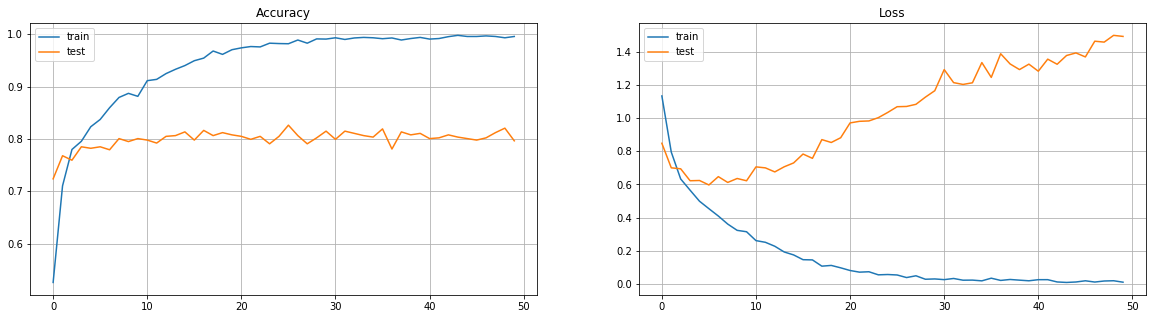

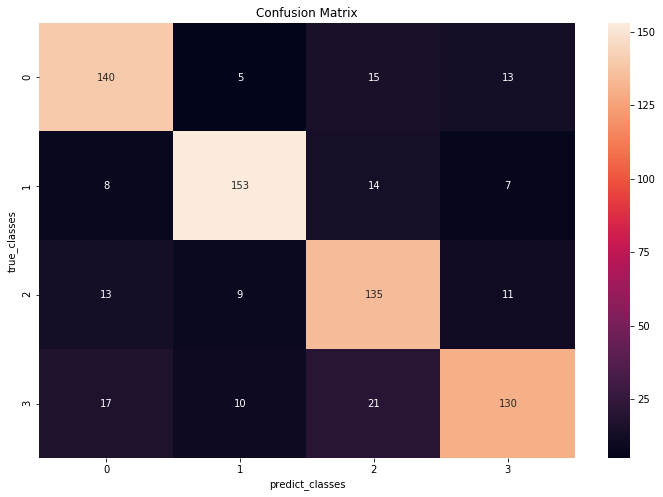

処理時間：7.054025888442993[s]


,text,true_label,pre_label,prediction
0,「これは可愛い」 佐々木希の後継、ブレイク必至の新EUROガール,スポーツ,ライフ,0.782236
1,「アメトーーク!」“カープ芸人”の回に、広島・石井は「少し考えてほしかった」,スポーツ,映画,0.747414
2,「石原軍団っぽい」本田圭佑の広告に爆笑の嵐,スポーツ,IT,0.968763
3,【Sports Watch】15歳の高木美帆、初五輪は“会社員でいう研修期間”,スポーツ,IT,0.733087
4,【Sports Watch】TBSの新スポーツ番組はどうだった？（3）不安定な初回放送を露呈,スポーツ,IT,0.999996
5,【Sports Watch】“三束のわらじ”谷亮子に不名誉な記録が・・・,スポーツ,ライフ,0.990745
6,【Sports Watch】「こんなんじゃ戦えません」澤が乗り越えた最大のピンチとは？,スポーツ,映画,0.995598
7,【Sports Watch】なでしこジャパンにアウェーの洗礼 “練習場にはゴルフボ...,スポーツ,ライフ,0.487597
8,【Sports Watch】ドイツ女子U20代表がセクシーすぎるヌード披露,スポーツ,映画,0.700033
9,【Sports Watch】不振続く松井秀に「マイナーでのプレーを余儀なくされる」,スポーツ,映画,0.693448


In [7]:
MLP_dmpv(A_index_c[2], B_index_c[2], C_index_c[2], D_index_c[2], E_index_c[2], F_index_c[2], x_size, p=2)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 1s 372us/step - loss: 1.1453 - acc: 0.5020 - val_loss: 0.8930 - val_acc: 0.7375
Epoch 2/50
2807/2807 [==============================] - 0s 54us/step - loss: 0.7988 - acc: 0.7032 - val_loss: 0.7094 - val_acc: 0.7689
Epoch 3/50
2807/2807 [==============================] - 0s 37us/step - loss: 0.6660 - acc: 0.7563 - val_loss: 0.6248 - val_acc: 0.7760
Epoch 4/50
2807/2807 [==============================] - 0s 40us/step - loss: 0.5699 - acc: 0.7980 - val_loss: 0.6061 - val_acc: 0.7960
Epoch 5/50
2807/2807 [==============================] - 0s 36us/step - loss: 0.5061 - acc: 0.8254 - val_loss: 0.6103 - val_acc: 0.7989
Epoch 6/50
2807/2807 [==============================] - 0s 36us/step - loss: 0.4572 - acc: 0.8383 - val_loss: 0.6043 - val_acc: 0.8046
Epoch 7/50
2807/2807 [==============================] - 0s 36us/step - loss: 0.4002 - acc: 0.8668 - val_loss: 0.6049 - val_acc: 0.8060
Epoch 8

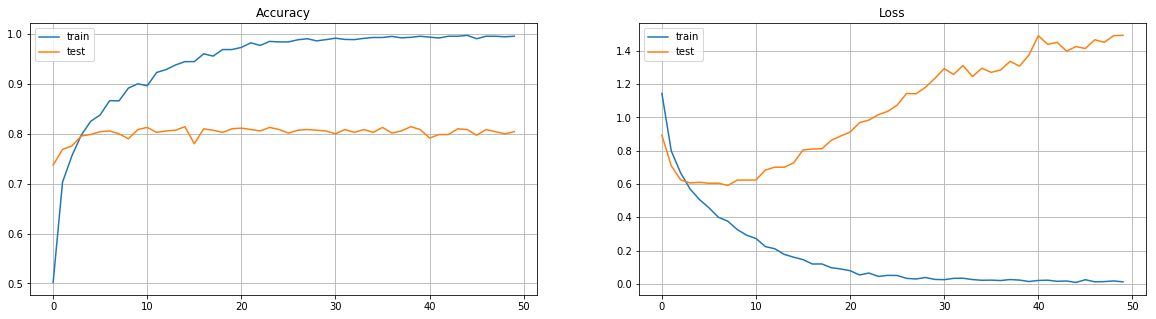

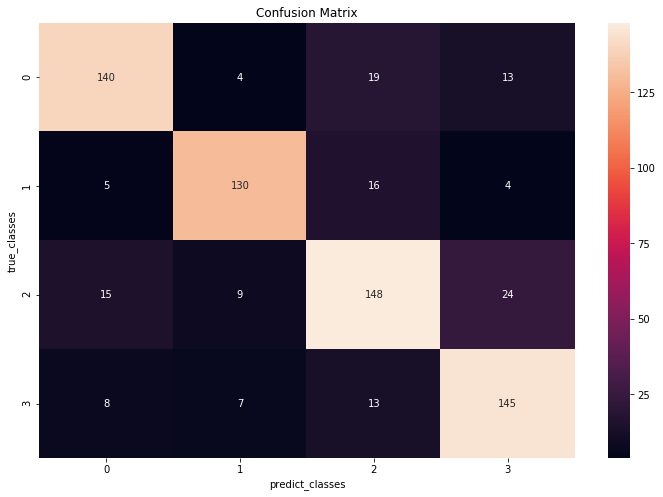

処理時間：7.8000712394714355[s]


,text,true_label,pre_label,prediction
0,「チャンスはある」 ベッカムがロンドン五輪で代表復帰か,スポーツ,映画,0.732445
1,「妖精・浅尾」に引けを取らない美貌の新パートナーとは？,スポーツ,映画,0.979349
2,「跳躍系の選手に美形が多い」徳光アナ一押しの女子アスリートとは,スポーツ,ライフ,0.708458
3,【Sports Watch】“満塁男”駒田氏が、最近の虐待事件に怒り露わ,スポーツ,IT,0.992677
4,【Sports Watch】“美人すぎる市議”、ジェイロックと契約を締結,スポーツ,映画,0.999953
5,【Sports Watch】“鬼嫁”北斗晶、リングネームの由来とは？,スポーツ,映画,0.645029
6,【Sports Watch】ショック、“鬼軍曹”山本小鉄氏が急逝,スポーツ,ライフ,0.997355
7,【Sports Watch】ナイナイ矢部、「優勝はスペインって言ったでしょ？」,スポーツ,ライフ,0.657465
8,【Sports Watch】原発事故で危機に立たされた女子アスリート,スポーツ,IT,0.580092
9,【Sports Watch】女優・片瀬那奈、CL決勝戦よりも——,スポーツ,ライフ,0.694213


In [8]:
MLP_dmpv(A_index_c[3], B_index_c[3], C_index_c[3], D_index_c[3], E_index_c[3], F_index_c[3], x_size, p=3)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 1s 413us/step - loss: 1.1310 - acc: 0.5251 - val_loss: 0.8481 - val_acc: 0.7118
Epoch 2/50
2807/2807 [==============================] - 0s 42us/step - loss: 0.7948 - acc: 0.7154 - val_loss: 0.7114 - val_acc: 0.7332
Epoch 3/50
2807/2807 [==============================] - 0s 57us/step - loss: 0.6726 - acc: 0.7638 - val_loss: 0.6581 - val_acc: 0.7632
Epoch 4/50
2807/2807 [==============================] - 0s 54us/step - loss: 0.5635 - acc: 0.8009 - val_loss: 0.6683 - val_acc: 0.7675
Epoch 5/50
2807/2807 [==============================] - 0s 52us/step - loss: 0.5042 - acc: 0.8240 - val_loss: 0.6278 - val_acc: 0.7817
Epoch 6/50
2807/2807 [==============================] - 0s 41us/step - loss: 0.4563 - acc: 0.8482 - val_loss: 0.6095 - val_acc: 0.7946
Epoch 7/50
2807/2807 [==============================] - 0s 36us/step - loss: 0.4156 - acc: 0.8603 - val_loss: 0.6062 - val_acc: 0.7960
Epoch 8

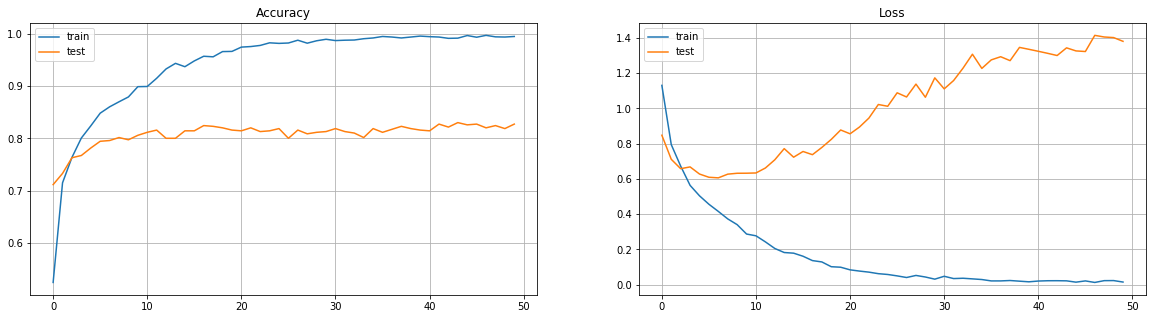

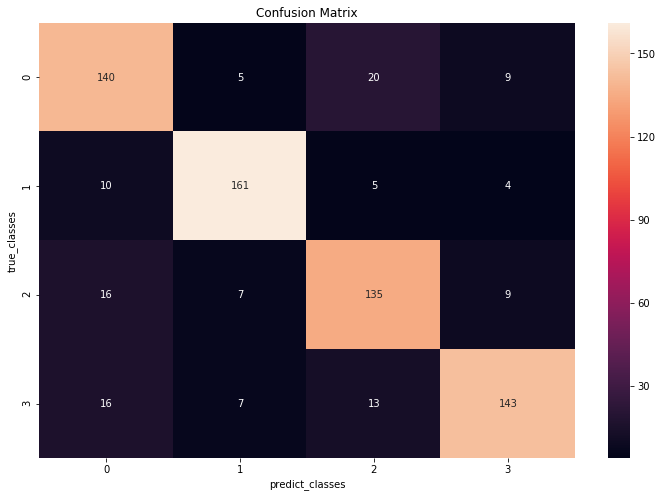

処理時間：7.949270009994507[s]


,text,true_label,pre_label,prediction
0,J歴代6位の年俸から、“見事な右肩下がり”で落ちていった武田修宏,スポーツ,IT,0.996466
1,“岩崎恭子の再来”、天才美少女スイマーが本日登場！,スポーツ,IT,0.999995
2,「平成のマーメイド」は15歳、最年少の美少女スイマー,スポーツ,映画,0.974691
3,「格が違う」かわいい子だらけのなでしこ候補たち,スポーツ,ライフ,0.999954
4,【Sports Watch】グランパス主力メンバー、ストイコビッチ監督を絶賛,スポーツ,映画,0.503185
5,【Sports Watch】ゴール後のパフォーマンスで話題の日本代表・槙野、新ネタ明かす,スポーツ,映画,0.997585
6,【Sports Watch】ダルビッシュに第二子が誕生,スポーツ,映画,0.636714
7,【Sports Watch】元大関・千代大海、M-1王者にガン飛ばした,スポーツ,映画,0.988237
8,【Sports Watch】内田篤人キッパリ！ 「よくないすか？ べつに。サッカー選手て...,スポーツ,映画,0.777941
9,【Sports Watch】大人気ラウンドガールがCM出演、セクシーボディを披露!!,スポーツ,映画,0.999977


In [9]:
MLP_dmpv(A_index_c[4], B_index_c[4], C_index_c[4], D_index_c[4], E_index_c[4], F_index_c[4], x_size, p=4)

# dbow

In [10]:
def MLP_dbow(x_test, x_train, y_test, y_train, z_test, z_train, x_size, p):
    # MLPモデル構造を定義 --- (*5)
    MLP_model = Sequential()

    MLP_model.add(Dense(128, activation='relu', input_shape=(x_size,)))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(nb_classes, activation='softmax'))

    # モデルをコンパイル --- (*6)
    MLP_model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    t1 = time.time()                 #　開始
    # 学習を実行 --- (*7)
    hist = MLP_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time.time()                #　終了
    
   # モデルの保存
    MLP_model.save('./model/dbow_model_'+str(p)+'.hdf5')
    
    # モデルのロード
    model = load_model('./model/dbow_model_'+str(p)+'.hdf5')
    #  混同行列
    predict_classes = model.predict_classes(x_test[1:10000]) ### 予測したラベルを取得
    true_classes = np.argmax(y_test[1:10000], 1) ### 実際のラベルを取得

    # 評価する ---(*8)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('\n')
    print("正解率=", score[1], 'loss=', score[0])

    #  適応率, 再現率, F値
    rep = metrics.classification_report(true_classes, predict_classes)
    print(rep)

    # 学習の様子をグラフへ描画 --- (*10)
    # Accuracy
    plt.figure(figsize=(20, 5)) # figureの縦横の大きさ
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    MLP_print_cmx(true_classes, predict_classes)

    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"処理時間：{elapsed_time}"+"[s]")

    LABELS = ["スポーツ", "IT", "映画", "ライフ"]
    A=[]
    B=[]
    C=[]
    D=[]
    for i, j, k in zip(x_test, y_test, z_test):
        pre = MLP_model.predict(np.array([i]))[0]
        n = pre.argmax()
        l=np.where(j==1.0)
        if LABELS[n]!=LABELS[l[0][0]]:
            A.append(LABELS[n])
            B.append(pre[n])
            C.append(LABELS[l[0][0]])
            D.append(k)

    df=pd.DataFrame({'text':D,
                                     'true_label':C, 
                                    'pre_label':A,
                                    'prediction':B}
                                   )

    #     df.to_excel('Excel/TF-IDF_MLP_'+str(p)+'.xlsx', encoding='UTF-16')
    display(df)

In [11]:
data_s=pickle.load(open('/Users/Baron/Document/text_mining/Data/pickle/Doc2Vec/Headline/d2v_headline_dbow.pickle', "rb"))
z_s = data_s[0]   # 内容
y_s = data_s[1]   # ラベル
x_s = data_s[2]   # 特徴量
kf = KFold(n_splits=5, shuffle=True, random_state=0)
nb_classes = 4
# ラベルデータをone-hotベクトルに直す --- (*3)
y_s = keras.utils.np_utils.to_categorical(y_s, nb_classes)

# データの次元数
x_size = x_s[0].shape[0]
y_size = y_s[0].shape[0]

A_index_s=[]
B_index_s=[]
C_index_s=[]
D_index_s=[]
E_index_s=[]
F_index_s=[]

# 交差検証
for train, test in kf.split(x_s):
    A_s=np.empty((0,x_size), int)
    B_s=np.empty((0,x_size), int)
    C_s=np.empty((0,y_size), int)
    D_s=np.empty((0,y_size), int)
    E_s = []
    F_s = []
    for i in test:
        A_s = np.append(A_s, [x_s[i]], axis=0)           # x_test
        C_s = np.append(C_s, [y_s[i]], axis=0)           # y_test
        E_s.append(z_s[i])                                     # z_test
    A_index_s.append(A_s)
    C_index_s.append(C_s)
    E_index_s.append(E_s)
    for j in train:
        B_s = np.append(B_s, [x_s[j]], axis=0)            # x_train
        D_s = np.append(D_s, [y_s[j]], axis=0)           # y_train
        F_s.append(z_s[j])                                      # z_train
    B_index_s.append(B_s)
    D_index_s.append(D_s)
    F_index_s.append(F_s)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 2s 733us/step - loss: 1.1854 - acc: 0.5061 - val_loss: 0.8477 - val_acc: 0.7123
Epoch 2/50
2806/2806 [==============================] - 0s 37us/step - loss: 0.8125 - acc: 0.6960 - val_loss: 0.6415 - val_acc: 0.7692
Epoch 3/50
2806/2806 [==============================] - 0s 42us/step - loss: 0.6907 - acc: 0.7455 - val_loss: 0.5915 - val_acc: 0.7721
Epoch 4/50
2806/2806 [==============================] - 0s 50us/step - loss: 0.6008 - acc: 0.7801 - val_loss: 0.5520 - val_acc: 0.7892
Epoch 5/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.5465 - acc: 0.8004 - val_loss: 0.5072 - val_acc: 0.8063
Epoch 6/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.4981 - acc: 0.8207 - val_loss: 0.4970 - val_acc: 0.8134
Epoch 7/50
2806/2806 [==============================] - 0s 49us/step - loss: 0.4314 - acc: 0.8453 - val_loss: 0.4779 - val_acc: 0.8348
Epoch 8

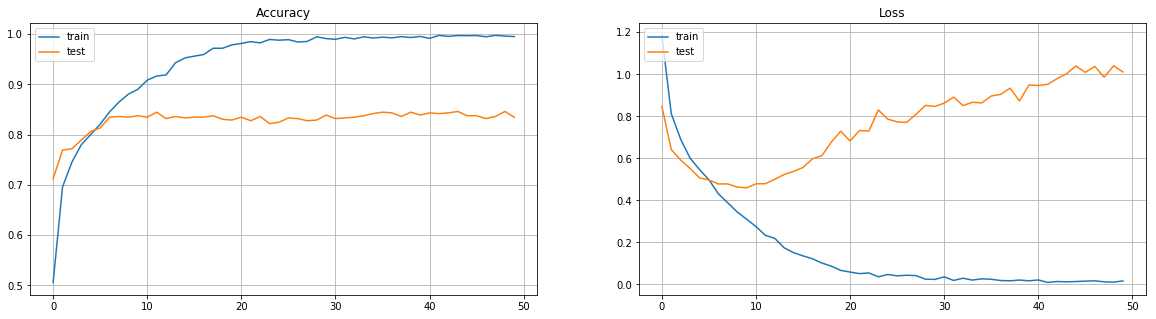

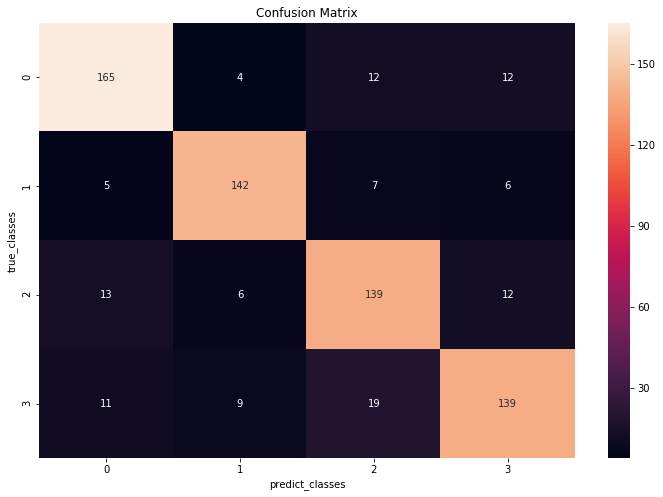

処理時間：9.791079044342041[s]


,text,true_label,pre_label,prediction
0,CSに向けリハビリ中の松中に中年ファンの心ない暴言,スポーツ,映画,0.648256
1,“史上最低の外国人選手”が母国でツイッター更新、ファンの怒りは増幅,スポーツ,ライフ,0.980151
2,【Sports Watch】アントニオ猪木、幻の試合映像が公開,スポーツ,映画,0.960162
3,【Sports Watch】シャワポワを追いつめた17歳美女とは？,スポーツ,映画,0.861761
4,【Sports Watch】モデル業を捨てた卓球美少女,スポーツ,ライフ,0.992674
5,【Sports Watch】亀田興毅が被災地に物資「子供達がちょっとでも元気になってく...,スポーツ,映画,0.999172
6,【Sports Watch】元代表選手が討論、日韓戦勝利のポイントとは？,スポーツ,映画,0.537484
7,【Sports Watch】宮崎大輔に、妻は“朝まで遊んで。スポーツ選手ですよ”,スポーツ,ライフ,0.919421
8,【Sports Watch】日本と激突!?驚愕テクニックを持つ“女ジダン”,スポーツ,IT,0.614984
9,【Sports Watch】松坂大輔「もう勝ったと思って寝るわ」→大逆転負け,スポーツ,映画,0.532384


In [12]:
MLP_dbow(A_index_s[0], B_index_s[0], C_index_s[0], D_index_s[0], E_index_s[0], F_index_s[0], x_size, p=0)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 2s 656us/step - loss: 1.1565 - acc: 0.5178 - val_loss: 0.8519 - val_acc: 0.6980
Epoch 2/50
2806/2806 [==============================] - 0s 50us/step - loss: 0.8060 - acc: 0.7099 - val_loss: 0.6928 - val_acc: 0.7450
Epoch 3/50
2806/2806 [==============================] - 0s 63us/step - loss: 0.6628 - acc: 0.7584 - val_loss: 0.6072 - val_acc: 0.7692
Epoch 4/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.5896 - acc: 0.7805 - val_loss: 0.6029 - val_acc: 0.7863
Epoch 5/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.5230 - acc: 0.8104 - val_loss: 0.5605 - val_acc: 0.7977
Epoch 6/50
2806/2806 [==============================] - 0s 43us/step - loss: 0.4871 - acc: 0.8321 - val_loss: 0.5658 - val_acc: 0.7949
Epoch 7/50
2806/2806 [==============================] - 0s 38us/step - loss: 0.4376 - acc: 0.8510 - val_loss: 0.5742 - val_acc: 0.8063
Epoch 8

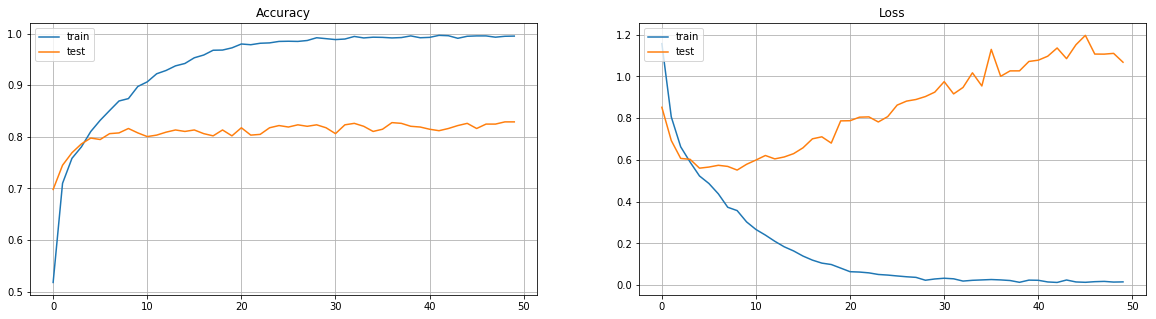

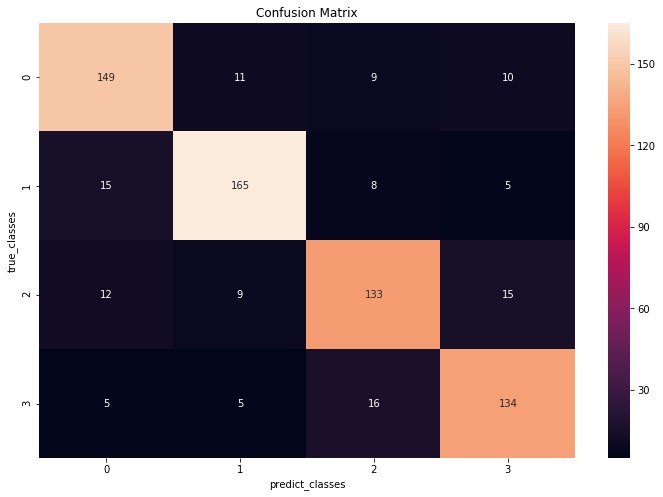

処理時間：9.669357061386108[s]


,text,true_label,pre_label,prediction
0,“日本の心臓”遠藤保仁の凄すぎるプレー、日本を救った1本のパスとは？,スポーツ,IT,0.999930
1,「これはひどすぎる」テニスの決勝戦で前代未聞の失格劇,スポーツ,IT,0.749059
2,「なぜ足で止めようと」自分の車に轢かれ今季絶望の選手,スポーツ,IT,0.999172
3,「泣いてんのかこれ」、“熱すぎる”アナウンサーが劇的結末に大興奮,スポーツ,映画,0.996823
4,【Sports Watch】まだまだいるぞ！ かわいい次世代なでしこ,スポーツ,ライフ,0.921618
5,【Sports Watch】ビーチバレー・浅尾、引退後の皮算用とは？,スポーツ,映画,0.770161
6,【Sports Watch】仕事中、サッチーから“もうやめて帰ってこい”と言われるノムさん,スポーツ,ライフ,0.999967
7,【Sports Watch】安藤美姫が近親者にモロゾフコーチを紹介“私、この人と結婚する”,スポーツ,ライフ,0.445404
8,【Sports Watch】広島-巨人戦の幕切れに 「どう見たってプロの試合じゃない」,スポーツ,映画,0.596416
9,【Sports Watch】斎藤を悩ませたストーカー問題とは？,スポーツ,ライフ,0.841467


In [13]:
MLP_dbow(A_index_s[1], B_index_s[1], C_index_s[1], D_index_s[1], E_index_s[1], F_index_s[1], x_size, p=1)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 2s 598us/step - loss: 1.1826 - acc: 0.4989 - val_loss: 0.9032 - val_acc: 0.7137
Epoch 2/50
2806/2806 [==============================] - 0s 46us/step - loss: 0.8104 - acc: 0.7078 - val_loss: 0.7296 - val_acc: 0.7678
Epoch 3/50
2806/2806 [==============================] - 0s 46us/step - loss: 0.6581 - acc: 0.7537 - val_loss: 0.6552 - val_acc: 0.7607
Epoch 4/50
2806/2806 [==============================] - 0s 63us/step - loss: 0.5685 - acc: 0.7880 - val_loss: 0.6229 - val_acc: 0.7735
Epoch 5/50
2806/2806 [==============================] - 0s 64us/step - loss: 0.4992 - acc: 0.8207 - val_loss: 0.6635 - val_acc: 0.7578
Epoch 6/50
2806/2806 [==============================] - 0s 45us/step - loss: 0.4550 - acc: 0.8403 - val_loss: 0.6005 - val_acc: 0.7963
Epoch 7/50
2806/2806 [==============================] - 0s 60us/step - loss: 0.3842 - acc: 0.8685 - val_loss: 0.6182 - val_acc: 0.7877
Epoch 8

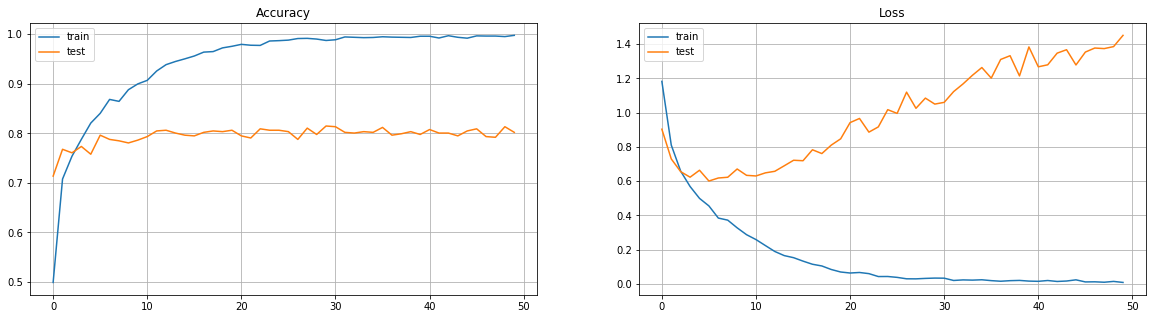

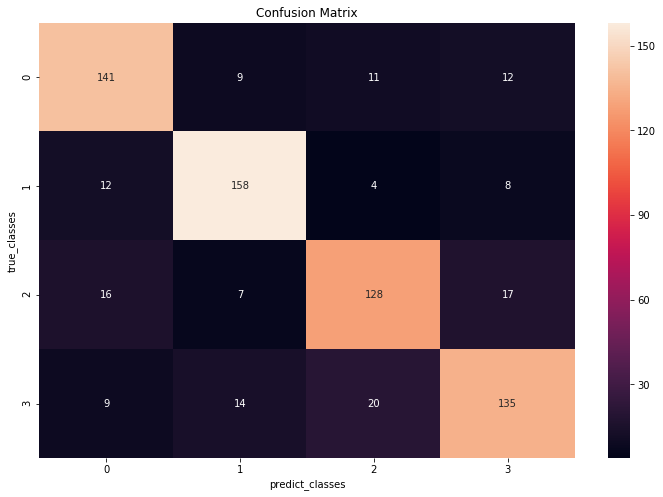

処理時間：9.356703996658325[s]


,text,true_label,pre_label,prediction
0,「うどん県」ロゴ採用に「罰ゲームか」の声,スポーツ,IT,0.967418
1,「アメトーーク!」“カープ芸人”の回に、広島・石井は「少し考えてほしかった」,スポーツ,ライフ,0.979861
2,「石原軍団っぽい」本田圭佑の広告に爆笑の嵐,スポーツ,IT,0.999995
3,「酷すぎる」選抜高校野球に誤審続出,スポーツ,IT,0.572296
4,【Sports Watch】「こんなんじゃ戦えません」澤が乗り越えた最大のピンチとは？,スポーツ,映画,0.853689
5,【Sports Watch】キム・ヨナに質問、“恋の方はどうですか？”,スポーツ,ライフ,0.637365
6,【Sports Watch】サッチーvsミッチー実現なるか？ プロレス団体名は「SMAP」に？？,スポーツ,映画,0.776314
7,【Sports Watch】ロッテの歴史的死闘、試合中の選手の心境は？,スポーツ,映画,0.749050
8,【Sports Watch】佑ちゃんの弱点「真っ直ぐと変化球のフォームが違い過ぎる」,スポーツ,IT,0.971993
9,【Sports Watch】元プロレス雑誌編集長が告白「馬場から裏金をもらっていた」,スポーツ,IT,0.781764


In [14]:
MLP_dbow(A_index_s[2], B_index_s[2], C_index_s[2], D_index_s[2], E_index_s[2], F_index_s[2], x_size, p=2)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 2s 778us/step - loss: 1.1537 - acc: 0.5151 - val_loss: 0.9110 - val_acc: 0.6248
Epoch 2/50
2807/2807 [==============================] - 0s 50us/step - loss: 0.7963 - acc: 0.7011 - val_loss: 0.7554 - val_acc: 0.7332
Epoch 3/50
2807/2807 [==============================] - 0s 44us/step - loss: 0.6574 - acc: 0.7620 - val_loss: 0.7072 - val_acc: 0.7504
Epoch 4/50
2807/2807 [==============================] - 0s 44us/step - loss: 0.5818 - acc: 0.7927 - val_loss: 0.6836 - val_acc: 0.7646
Epoch 5/50
2807/2807 [==============================] - 0s 42us/step - loss: 0.5133 - acc: 0.8133 - val_loss: 0.6519 - val_acc: 0.7689
Epoch 6/50
2807/2807 [==============================] - 0s 42us/step - loss: 0.4532 - acc: 0.8465 - val_loss: 0.6908 - val_acc: 0.7575
Epoch 7/50
2807/2807 [==============================] - 0s 42us/step - loss: 0.3991 - acc: 0.8632 - val_loss: 0.6320 - val_acc: 0.7860
Epoch 8

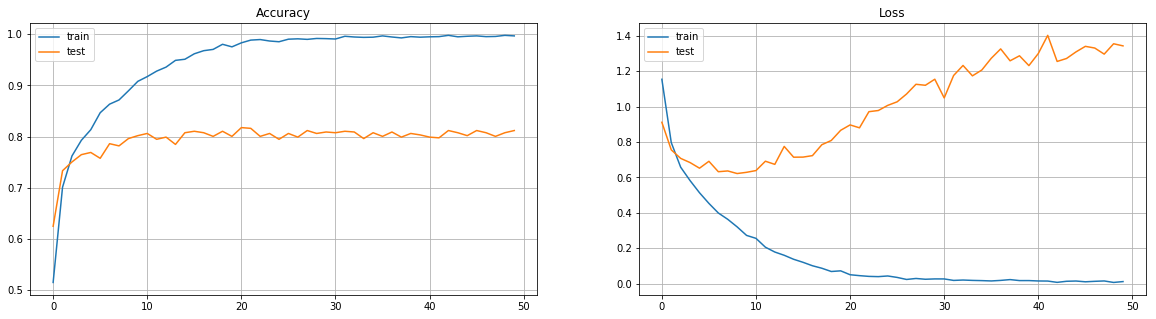

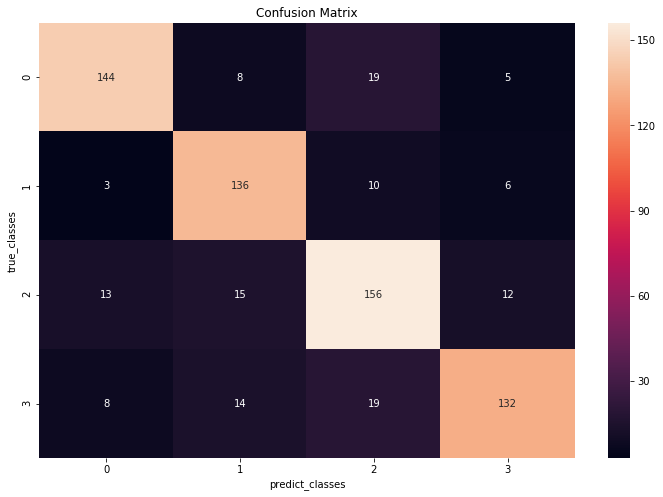

処理時間：9.00328278541565[s]


,text,true_label,pre_label,prediction
0,“東洋の美女”軍団が東京の空に舞う,スポーツ,映画,0.999961
1,「チャンスはある」 ベッカムがロンドン五輪で代表復帰か,スポーツ,IT,1.000000
2,「結果を残して1％でも近付けたら」 香川真司が夢を語る,スポーツ,映画,0.999968
3,【Sports Watch】“左のおかわり君”坂田「去年は全く歯が立たなかった」,スポーツ,IT,0.998258
4,【Sports Watch】“恋したい”浅田真央が苦笑い 「残念ですね」,スポーツ,映画,0.999996
5,【Sports Watch】“美人すぎる市議”、ジェイロックと契約を締結,スポーツ,映画,0.998034
6,【Sports Watch】「川澄かわいい」彗星のごとく現れたニューヒロイン,スポーツ,映画,0.993257
7,【Sports Watch】ヴェルディ財政難に、ラモスが悲痛の訴え,スポーツ,映画,0.992753
8,【Sports Watch】ゴン中山、退屈なゲームに「日本戦じゃなきゃ、寝てますね」,スポーツ,IT,0.869696
9,【Sports Watch】ザッケローニ監督、チェコ戦に向け宣言 「4-3-3も試してみる...,スポーツ,IT,0.999999


In [15]:
MLP_dbow(A_index_s[3], B_index_s[3], C_index_s[3], D_index_s[3], E_index_s[3], F_index_s[3], x_size, p=3)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 2s 868us/step - loss: 1.1763 - acc: 0.4916 - val_loss: 0.8621 - val_acc: 0.6961
Epoch 2/50
2807/2807 [==============================] - 0s 41us/step - loss: 0.8222 - acc: 0.6972 - val_loss: 0.6869 - val_acc: 0.7447
Epoch 3/50
2807/2807 [==============================] - 0s 40us/step - loss: 0.6742 - acc: 0.7488 - val_loss: 0.6460 - val_acc: 0.7589
Epoch 4/50
2807/2807 [==============================] - 0s 39us/step - loss: 0.5905 - acc: 0.7976 - val_loss: 0.6242 - val_acc: 0.7689
Epoch 5/50
2807/2807 [==============================] - 0s 41us/step - loss: 0.5311 - acc: 0.8147 - val_loss: 0.5966 - val_acc: 0.7874
Epoch 6/50
2807/2807 [==============================] - 0s 71us/step - loss: 0.4805 - acc: 0.8351 - val_loss: 0.5680 - val_acc: 0.7974
Epoch 7/50
2807/2807 [==============================] - 0s 54us/step - loss: 0.4283 - acc: 0.8436 - val_loss: 0.5587 - val_acc: 0.8031
Epoch 8

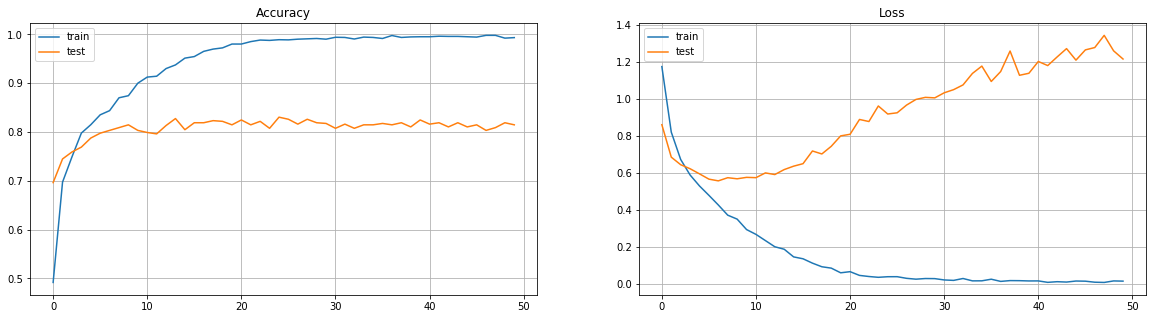

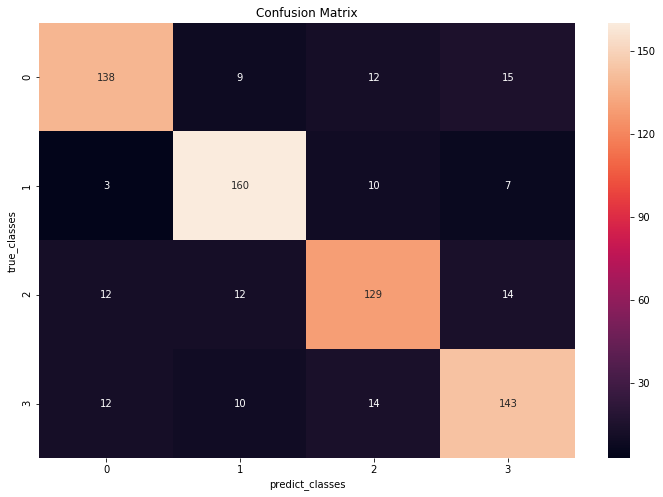

処理時間：10.283068895339966[s]


,text,true_label,pre_label,prediction
0,J歴代6位の年俸から、“見事な右肩下がり”で落ちていった武田修宏,スポーツ,IT,0.926258
1,“市民ランナー”川内優輝の母明かす、「今思うとやり過ぎだった」壮絶練習とは,スポーツ,映画,1.000000
2,「長谷部放出」は誤訳？ライターが指摘,スポーツ,IT,0.999962
3,【Sports Watch】“敗者おっぱい丸出しマッチ” その顛末は？？,スポーツ,IT,0.490415
4,【Sports Watch】アイドルレスラー・風香が病気を告白,スポーツ,IT,0.918657
5,【Sports Watch】亀田興に、絢香似の彼女がラブレター “ホンマ自慢の彼氏です”,スポーツ,ライフ,0.974495
6,【Sports Watch】人気女子ゴルファー、苦難の時代を語る,スポーツ,ライフ,0.997462
7,【Sports Watch】大人気ラウンドガールがCM出演、セクシーボディを披露!!,スポーツ,映画,1.000000
8,【Sports Watch】川島、複雑なチーム事情に「正直意味が分からない」,スポーツ,映画,0.813433
9,【Sports Watch】最強ミランのサポート施設「ミランラボ」とは？,スポーツ,IT,0.999975


In [16]:
MLP_dbow(A_index_s[4], B_index_s[4], C_index_s[4], D_index_s[4], E_index_s[4], F_index_s[4], x_size, p=4)

# グリッドサーチ

In [17]:
# # コピー2
# def MLP_grid(activation, optimizer, out_dim):
#     # MLPモデル構造を定義 --- (*5)
#     MLP_model = Sequential()
#     #  隠れ層     
#     MLP_model.add(Dense(out_dim, activation=activation, input_shape=(x_size,)))
#     MLP_model.add(Dropout(0.2))
#     MLP_model.add(Dense(out_dim, activation=activation))
#     MLP_model.add(Dropout(0.2))
#     #  出力層
#     MLP_model.add(Dense(nb_classes, activation='softmax'))

#     # モデルをコンパイル --- (*6)
#     MLP_model.compile(
#         loss='categorical_crossentropy',
#         optimizer=optimizer,
#         metrics=['accuracy'])
#     return MLP_model    

In [18]:
# # データを返す関数
# def data(i):
#     # x_train, y_train, x_test, y_test
#     return B_index[i], D_index[i], A_index[i], C_index[i]

In [19]:
# activation = ["relu"]
# optimizer = ["rmsprop"]
# out_dim=[128]
# nb_epoch = [10, 20, 50]
# batch_size = [16, 64, 128]
# model = KerasClassifier(build_fn=MLP_gird, verbose=0)
# param_grid = dict(activation=activation, 
#                                 optimizer=optimizer, 
#                                 out_dim=out_dim, 
#                                 nb_epoch=nb_epoch, 
#                                 batch_size=batch_size)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [20]:
# # Data[0]:x_train, Data[1]:y_train, Data[2]:x_test, Data[3]:y_test
# grid_result = grid.fit(data(i=0)[0], data(i=0)[1])

In [21]:
# print (grid_result.best_score_)
# print (grid_result.best_params_)

In [22]:
# clf = grid_result.best_estimator_
# for t in range(5):
#     accuracy = clf.score(data(i=0)[i], data(i=0)[i])
#     print("\nAccuracy: %.2f" % (accuracy))